# Atividade 03 – Modelo Não Linear para o Alto-Falante

Nesta atividade, o modelo do alto-falante é aprimorado para incorporar a não linearidade no fator de força \(B_l\). Diferentemente do modelo linear, onde \(B_l\) é constante, agora seu valor varia em função do deslocamento do cone, \(x\). Especificamente:

- **Região Linear (\(|x| \leq x_1\))**:  
  \(B_l\) mantém o valor constante utilizado no modelo linear.

- **Região Nula (\(|x| \geq x_2\))**:  
  \(B_l\) é anulada, ou seja, o alto-falante não gera força além desse limite.

- **Região de Transição (\(x_1 < |x| < x_2\))**:  
  \(B_l\) decai de maneira suave seguindo uma função polinomial de ordem 2.

Os limites \(x_1\) e \(x_2\) são determinados com base na excursão máxima do cone, obtida no modelo linear (por exemplo, 75% e 150% do valor máximo). Com essa modificação, o sistema é simulado utilizando um sinal de entrada senoidal para análise da resposta em frequência e também por meio de um sinal de áudio medido. O intuito é comparar os resultados e avaliar o impacto da não linearidade no desempenho do alto-falante.


In [1]:
# =============================================================================
# Importação de pacotes
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d, splrep, splev
from scipy.io import wavfile
from IPython.display import clear_output

In [2]:
# =============================================================================
# Seção 1: Parâmetros do sistema e definição do modelo não linear
# =============================================================================
# Parâmetros físicos do alto-falante
m  = 14.35e-3    # Massa (kg)
b  = 0.786       # Coeficiente de amortecimento (kg/s)
k  = 1852        # Rigidez (N/m)
Bl = 4.95        # Constante eletromagnética nominal (N/A)
L  = 266e-6      # Indutância (H)
R  = 3.3         # Resistência (Ohms)

# Valor x_abs_max (valor obtidos na Atividade 01) 
x_abs_max = 0.00027148858093880836 

# Definição dos limites: 75% e 150% do deslocamento máximo
x1 = 0.75 * x_abs_max
x2 = 1.5  * x_abs_max

def B_l_nl(x):
    """
    Função não linear para o fator de força B_l(x).
    - Se |x| <= x1, opera no regime linear: retorna Bl.
    - Se |x| >= x2, a força é anulada: retorna 0.
    - Caso contrário, aplica uma variação quadrática.
    """
    if abs(x) <= x1:
        return Bl
    elif abs(x) >= x2:
        return 0.0
    else:
        # Coeficiente para variação quadrática
        a = Bl / (x2 - x1)**2
        if x > 0:
            return a * (x - x2)**2
        else:
            return a * (x + x2)**2

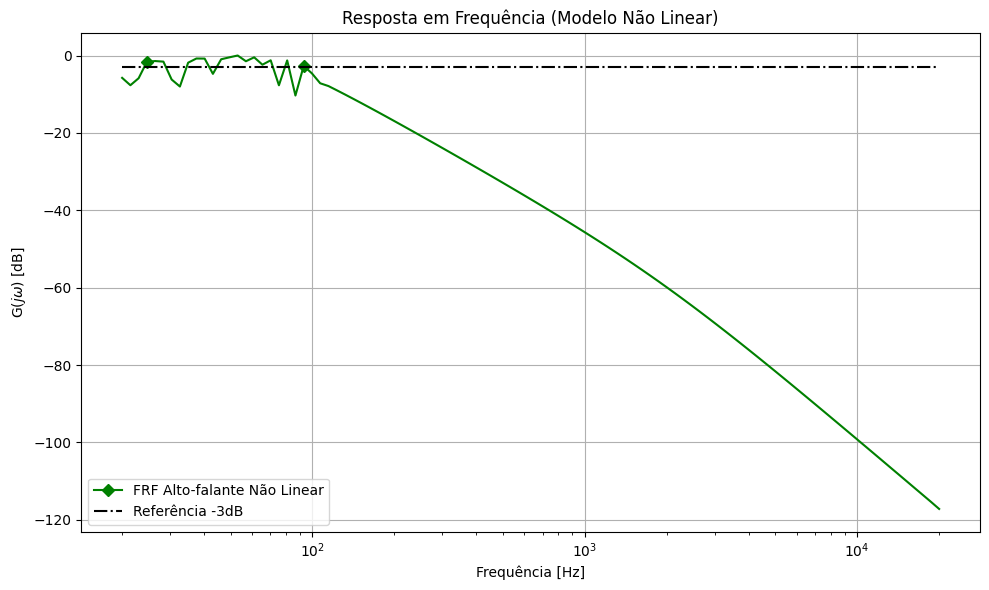

f_min (Hz) = 24.66
f_max (Hz) = 92.83
Largura de Banda (Hz) = 68.17


In [3]:
# =============================================================================
# Seção 2: Simulação da Resposta em Frequência com Modelo Não Linear
# =============================================================================
# Definir faixa de frequências para análise
fmin    = 20       # Frequência mínima (Hz)
fmax    = 20e3     # Frequência máxima (Hz)
npoints = 100
frequencies = np.logspace(np.log10(fmin), np.log10(fmax), npoints)
omega       = 2 * np.pi * frequencies

# Tempo de simulação para cada frequência (regime transitório mais curto)
duration = 0.05            # duração em segundos
sampling_rate_sim = 200e3  # taxa de amostragem para a simulação
t_sim = np.arange(0, duration, 1 / sampling_rate_sim)

def speaker_nonlinear(t, y, freq):
    """
    Modela as equações diferenciais do alto-falante incorporando o B_l não linear.
    Entrada u(t) é uma senóide com 1 V de amplitude para simular a resposta ao sinal
    de teste para cada frequência.
    """
    i, x, v = y
    u = np.sin(2 * np.pi * freq * t)  # Sinal de entrada senoidal (1 V amplitude)
    
    # B_l é calculado a cada instante considerando a posição x
    Bl_val = B_l_nl(x)
    
    # Equações do sistema
    di_dt = (-R * i - Bl_val * v + u) / L
    dx_dt = v
    dv_dt = (Bl_val * i - k * x - b * v) / m
    return [di_dt, dx_dt, dv_dt]

# Loop para simular a resposta em frequência (regime permanente na variável de estado 'x')
G_nl = []  # Lista para armazenar a resposta de amplitude (deslocamento)
for freq in frequencies:
    sol = solve_ivp(speaker_nonlinear, [0, duration], [0, 0, 0],
                    args=(freq,), t_eval=t_sim, method='RK45', max_step=1e-5)
    # Extrai o deslocamento (segunda variável de estado)
    x_sol = sol.y[1]
    # Considera os últimos 10% da simulação para regime permanente
    steady_state = x_sol[int(len(x_sol) * 0.9):]
    amplitude_response = np.max(np.abs(steady_state))
    G_nl.append(amplitude_response)

# Converte para dB e normaliza (pico em 0 dB)
G_nl = np.array(G_nl)
FRF_nl = 20 * np.log10(np.abs(G_nl))
FRF_nl = FRF_nl - np.max(FRF_nl)

# Determina a banda passante (-3 dB)
indices_BW = np.flatnonzero(FRF_nl > -3)
fc_min = frequencies[indices_BW[0]]
fc_max = frequencies[indices_BW[-1]]
BW     = fc_max - fc_min

# Plot da resposta em frequência simulada (modelo não linear)
markers_on = [indices_BW[0], indices_BW[-1]]
plt.figure(figsize=(10, 6))
plt.semilogx(frequencies, FRF_nl, '-gD', markevery=markers_on, label="FRF Alto-falante Não Linear")
plt.semilogx([fmin, fmax], [-3, -3], '-.k', label="Referência -3dB")
plt.xlabel('Frequência [Hz]')
plt.ylabel('G($j\\omega$) [dB]')
plt.title('Resposta em Frequência (Modelo Não Linear)')
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
clear_output(wait=True)
plt.show()

print(f'f_min (Hz) = {fc_min:.2f}')
print(f'f_max (Hz) = {fc_max:.2f}')
print(f'Largura de Banda (Hz) = {BW:.2f}')

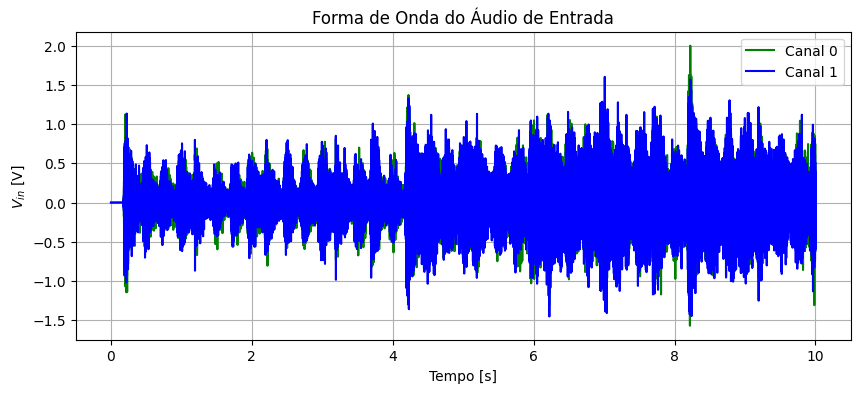

In [4]:
# =============================================================================
# Seção 3: Processamento do Áudio Medido e Comparação com Simulação
# =============================================================================
# Carrega o arquivo de áudio de entrada "sound.wav"
sample_rate, data = wavfile.read('TC02-in.wav')
clear_output(wait=True)

# Criação do vetor de tempo de acordo com o número de amostras e taxa de amostragem
num_samples = len(data)
duration_audio = num_samples / sample_rate
time_audio = np.linspace(0, duration_audio, num_samples)

# Se o áudio for estéreo, separa os canais (Canal 0 e Canal 1)
CH0 = data[:, 0]  # Canal 0
CH1 = data[:, 1]  # Canal 1

# Normaliza para que a amplitude máxima corresponda a 2 V
CH_max = np.max([np.max(np.abs(CH0)), np.max(np.abs(CH1))])
Amplitude = 2.0
CH0 = Amplitude * CH0 / CH_max
CH1 = Amplitude * CH1 / CH_max

# Plot da forma de onda do áudio de entrada
plt.figure(figsize=(10, 4))
plt.plot(time_audio, CH0, 'g', label='Canal 0')
plt.plot(time_audio, CH1, 'b', label='Canal 1')
plt.xlabel("Tempo [s]")
plt.ylabel("$V_{in}$ [V]")
plt.title("Forma de Onda do Áudio de Entrada")
plt.legend(loc="best")
plt.grid(True)
plt.show()

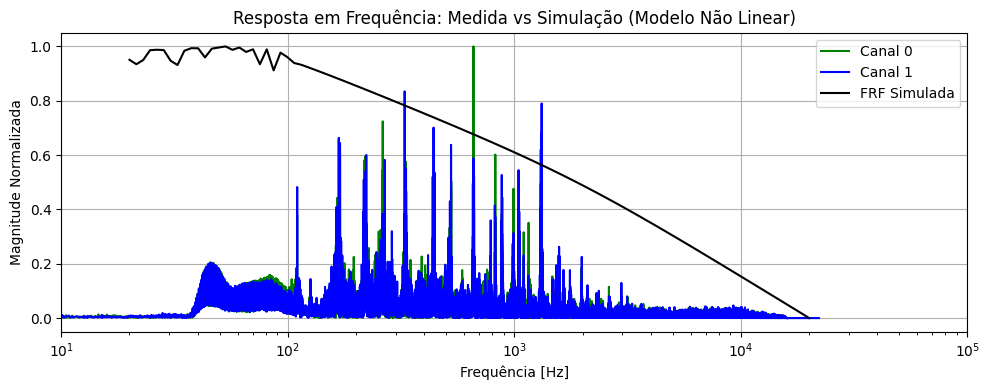

In [5]:
# =============================================================================
# Seção 4: FFT do Áudio Medido
# =============================================================================
N_fft = len(CH0)
fft_freqs = np.fft.fftfreq(N_fft, d=1/sample_rate)
fft_CH0 = np.fft.fft(CH0)
fft_CH1 = np.fft.fft(CH1)

magnitude_CH0 = np.abs(fft_CH0)
magnitude_CH1 = np.abs(fft_CH1)
CH_max_fft   = np.max([np.max(magnitude_CH0), np.max(magnitude_CH1)])

# Plot das respostas em frequência dos canais medidos
plt.figure(figsize=(10, 4))
plt.semilogx(fft_freqs[:N_fft // 2], magnitude_CH0[:N_fft // 2] / CH_max_fft, 'g', label='Canal 0')
plt.semilogx(fft_freqs[:N_fft // 2], magnitude_CH1[:N_fft // 2] / CH_max_fft, 'b', label='Canal 1')
# Para comparação, plota a FRF simulada (normalizada)
FRF_nl_norm = (FRF_nl - np.min(FRF_nl)) / np.ptp(FRF_nl)
plt.semilogx(frequencies, FRF_nl_norm, '-k', markevery=markers_on, label="FRF Simulada")
plt.title('Resposta em Frequência: Medida vs Simulação (Modelo Não Linear)')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude Normalizada')
plt.xlim(10, 1e5)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# =============================================================================
# Seção 5: Simulação da Resposta do Sistema com Modelo Não Linear usando Áudio Medido
# =============================================================================
# Cria funções interpoladoras para os sinais dos canais de áudio
ch0_interp = interp1d(time_audio, CH0, kind='linear', fill_value="extrapolate")
ch1_interp = interp1d(time_audio, CH1, kind='linear', fill_value="extrapolate")

# Funções que definem o sistema com B_l variável (modelo não linear)
def fch0(t, x):
    # x = [i, posição, velocidade]
    pos = x[1]
    Bl_val = B_l_nl(pos)
    
    A = np.array([[-R/L,      0,     -Bl_val/L],
                  [    0,      0,          1],
                  [Bl_val/m, -k/m,      -b/m]])
    B_vec = np.array([1/L, 0, 0])
    return A @ x + B_vec * ch0_interp(t)

def fch1(t, x):
    pos = x[1]
    Bl_val = B_l_nl(pos)
    
    A = np.array([[-R/L,      0,     -Bl_val/L],
                  [    0,      0,          1],
                  [Bl_val/m, -k/m,      -b/m]])
    B_vec = np.array([1/L, 0, 0])
    return A @ x + B_vec * ch1_interp(t)

# Resolução do sistema para cada canal com condição inicial nula
sol_CH0 = solve_ivp(fch0, [0, duration_audio], [0, 0, 0], t_eval=time_audio)
sol_CH1 = solve_ivp(fch1, [0, duration_audio], [0, 0, 0], t_eval=time_audio)

In [7]:
# =============================================================================
# Seção 6: Cálculo da Aceleração e Salvamento do Áudio de Saída
# =============================================================================
# Aceleração calculada a partir das variáveis de estado, levando em conta B_l não linear
acceleration_0 = np.zeros_like(sol_CH0.t)
acceleration_1 = np.zeros_like(sol_CH1.t)

for idx in range(len(sol_CH0.t)):
    # Para Canal 0
    pos0 = sol_CH0.y[1, idx]
    vel0 = sol_CH0.y[2, idx]
    curr0 = sol_CH0.y[0, idx]
    Bl0 = B_l_nl(pos0)
    acceleration_0[idx] = (Bl0/m) * curr0 - (k/m) * pos0 - (b/m) * vel0

    # Para Canal 1
    pos1 = sol_CH1.y[1, idx]
    vel1 = sol_CH1.y[2, idx]
    curr1 = sol_CH1.y[0, idx]
    Bl1 = B_l_nl(pos1)
    acceleration_1[idx] = (Bl1/m) * curr1 - (k/m) * pos1 - (b/m) * vel1

# Ajuste da aceleração para o vetor de tempo original (spline)
acc_0_interp = splev(time_audio, splrep(sol_CH0.t, acceleration_0))
acc_1_interp = splev(time_audio, splrep(sol_CH1.t, acceleration_1))

# Cria o sinal estéreo de saída e normaliza para evitar saturação
stereo_signal = np.column_stack((acc_0_interp, acc_1_interp))
stereo_signal = stereo_signal / np.max(np.abs(stereo_signal))
wavfile.write('TC02_nao_linear_out.wav', sample_rate, stereo_signal.astype(np.float32))

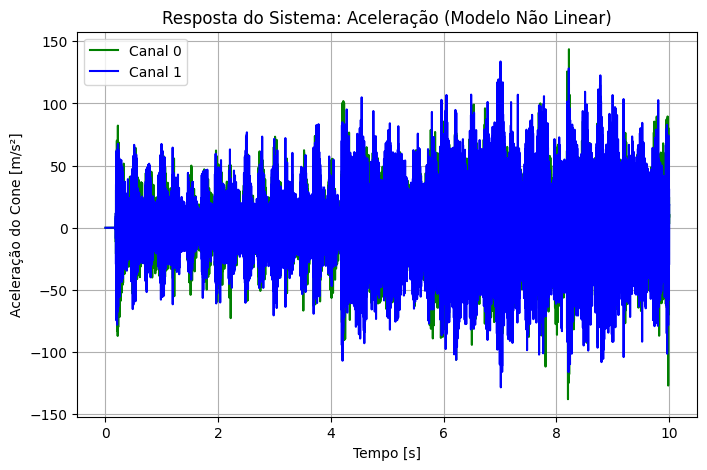

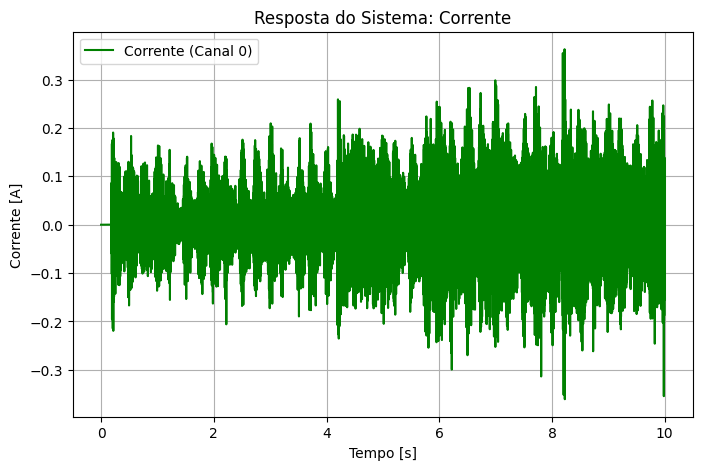

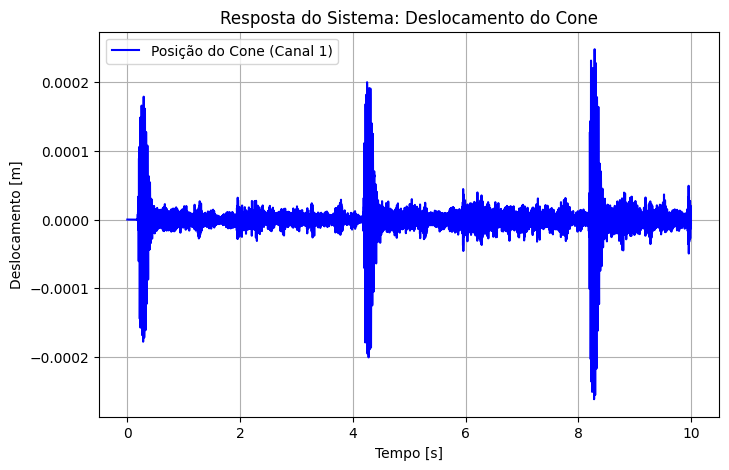

Deslocamento máximo (positivo) em CH1: 0.000248105245715534
Excursão máxima (valor absoluto) em CH1: 0.00026170658493958804


In [8]:
# =============================================================================
# Seção 7: Plot das Respostas do Sistema
# =============================================================================
# Plot da aceleração do cone (x¨(t))
plt.figure(figsize=(8,5))
plt.plot(time_audio, acc_0_interp, 'g', linewidth=1.5, label='Canal 0')
plt.plot(time_audio, acc_1_interp, 'b', linewidth=1.5, label='Canal 1')
plt.xlabel("Tempo [s]")
plt.ylabel("Aceleração do Cone [m/s²]")
plt.title("Resposta do Sistema: Aceleração (Modelo Não Linear)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plot da corrente (i(t))
plt.figure(figsize=(8,5))
plt.plot(sol_CH0.t, sol_CH0.y[0, :], 'g', linewidth=1.5, label='Corrente (Canal 0)')
plt.xlabel("Tempo [s]")
plt.ylabel("Corrente [A]")
plt.title("Resposta do Sistema: Corrente")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plot do deslocamento (x(t))
plt.figure(figsize=(8,5))
plt.plot(sol_CH1.t, sol_CH1.y[1, :], 'b', linewidth=1.5, label='Posição do Cone (Canal 1)')
plt.xlabel("Tempo [s]")
plt.ylabel("Deslocamento [m]")
plt.title("Resposta do Sistema: Deslocamento do Cone")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Exibe os valores de deslocamento máximo (valor positivo e valor absoluto) no canal 1
x_CH1 = sol_CH1.y[1, :]
x_max = np.max(x_CH1)
x_abs_max = np.max(np.abs(x_CH1))
print("Deslocamento máximo (positivo) em CH1:", x_max)
print("Excursão máxima (valor absoluto) em CH1:", x_abs_max)

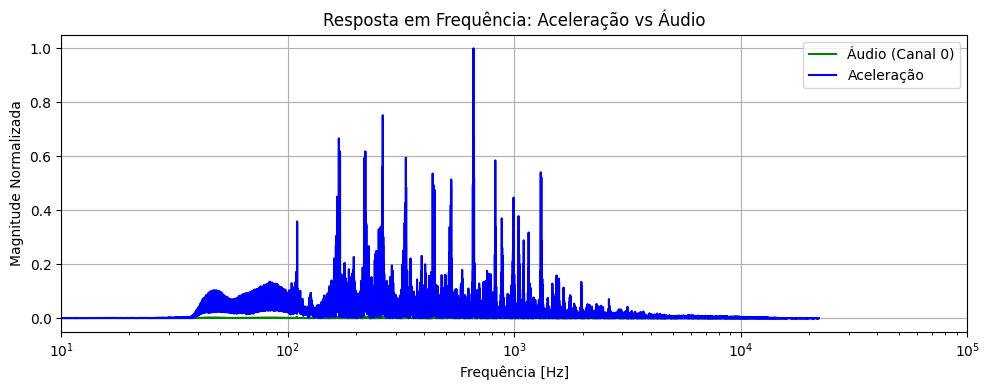

In [9]:
# =============================================================================
# Seção 8: Análise da Resposta em Frequência da Aceleração
# =============================================================================
N_acc = len(acc_0_interp)
fft_acc = np.fft.fft(acc_0_interp)
frequencies_acc = np.fft.fftfreq(N_acc, d=1/sample_rate)
magnitude_acc = np.abs(fft_acc)
magnitude_acc[0] = 0  # Remove a componente DC

CH_max_fft_acc = np.max(magnitude_acc)

plt.figure(figsize=(10, 4))
plt.semilogx(frequencies_acc[:N_acc // 2], magnitude_CH0[:N_acc // 2] / CH_max_fft_acc, 'g', label='Áudio (Canal 0)')
plt.semilogx(frequencies_acc[:N_acc // 2], magnitude_acc[:N_acc // 2] / CH_max_fft_acc, 'b', label='Aceleração')
plt.title('Resposta em Frequência: Aceleração vs Áudio')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude Normalizada')
plt.xlim(10, 1e5)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()